# 1. Introduction

This method is designed for astronomical sources featuring multiple bright, approximately point-like components. This example demonstrates its application using a model spectrum of two closely spaced point sources, characterized by the following parameters:

| Parameter | Value |
| :--- | :--- |
| Angular separation | 0.1 arcsec |
| Brightness ratio | ~4:1 |
| Slit width | 1 arcsec |
| Pixel scale | 0.4 arcsec/pixel |
| Readout noise | 3 e- |
| Slit orientation | Aligned with the source pair axis |
| Background | 5 ADU |
| Seeing | 1 arcsec |

Under these conditions, the binary system remains spatially unresolved (separation < pixel size), even before atmospheric blurring is considered, making it an ideal target for spectroastrometric analysis.

The core spectroastrometric procedure involves two main steps:
1.  Measuring the shift of the spectrum's centroid along the dispersion direction.
2.  Applying an algorithm to derive the angular source separation from this measured shift.

While real-world applications must account for instrumental artifacts (e.g., spectral curvature), this example presents a simplified, foundational example of the technique.

# 2. Example

**Prerequisite:** Review the [documentation](https://github.com/DmitryLashinMSU/Spectroastrometry_2.0). for the `Center_search` and `LCS_target` functions before proceeding.

In [1]:
from Spectroastrometry import *
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

First, let's prepare the data. We will extract the source spectra that were used to build the model. These will serve as a reference for comparison with our results.

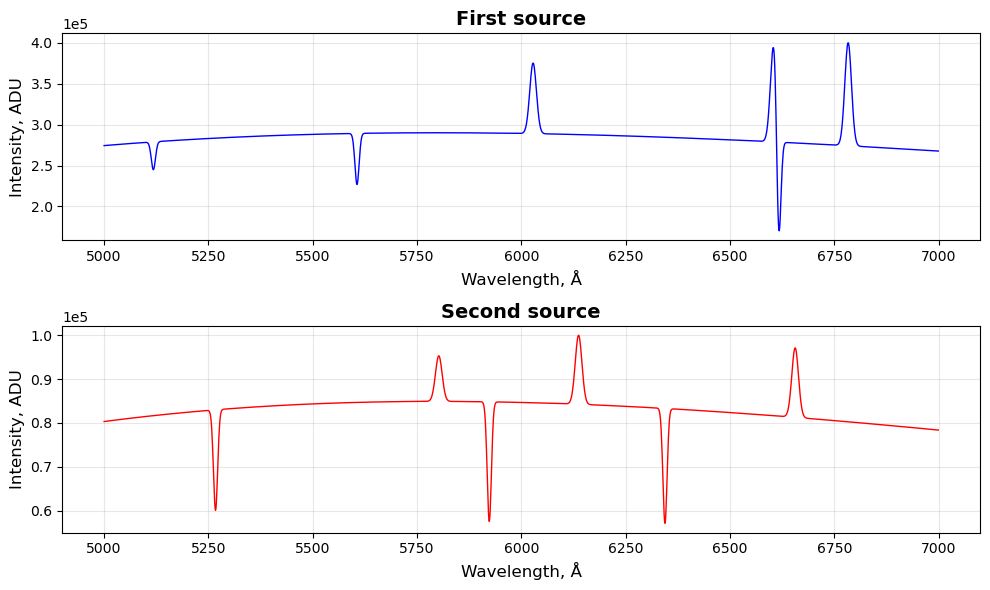

In [2]:
df = pd.read_csv('spectra.csv')

wl = df['Wavelengths']
Int1 = df['Int1']
Int2 = df['Int2']

fig1, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].plot(wl, Int1, color='blue', linewidth=1)
axes[0].set_title('First source', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Wavelength, Å', fontsize=12)
axes[0].set_ylabel('Intensity, ADU', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

axes[1].plot(wl, Int2, color='red', linewidth=1)
axes[1].set_title('Second source', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Wavelength, Å', fontsize=12)
axes[1].set_ylabel('Intensity, ADU', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.tight_layout()
plt.show()

Now, let's examine the frame we are going to process. We will extract its parameters and construct an image of the spectrum.

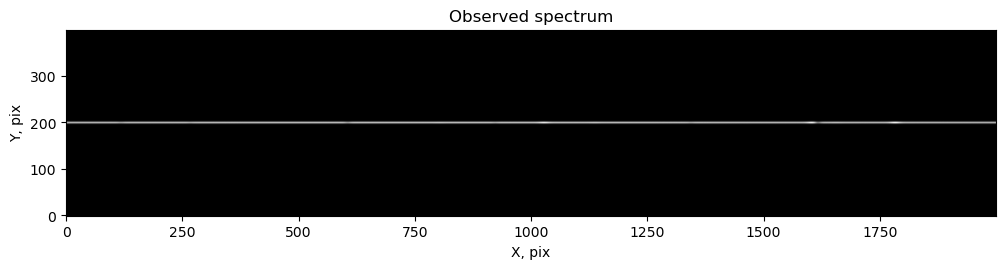

In [3]:
with fits.open("frame.fts") as hdul:
    image = hdul[0].data
    hdr = hdul[0].header

CRVAL1 = hdr.get("CRVAL1")     # starting wavelength, Å
CDELT1 = hdr.get("CDELT1")     # dispersion, Å / pix
image_size_X = image.shape[1]  # horizontal image size, pix
image_size_Y = image.shape[0]  # vertical image size, pix
Y_est = int(image_size_Y / 2)  # position of the spectrum center on the frame, pix

plt.figure(figsize=(12, 10))
plt.imshow(image, cmap='gray', origin='lower')
plt.title('Observed spectrum')
plt.xlabel('X, pix')
plt.ylabel('Y, pix')
plt.show()


Next, we proceed to the first stage of spectroastrometric processing: calculating the dependence of the spectrum center shift on wavelength. This is fully implemented in the `Center_search` function. We will display the obtained dependence on a plot.

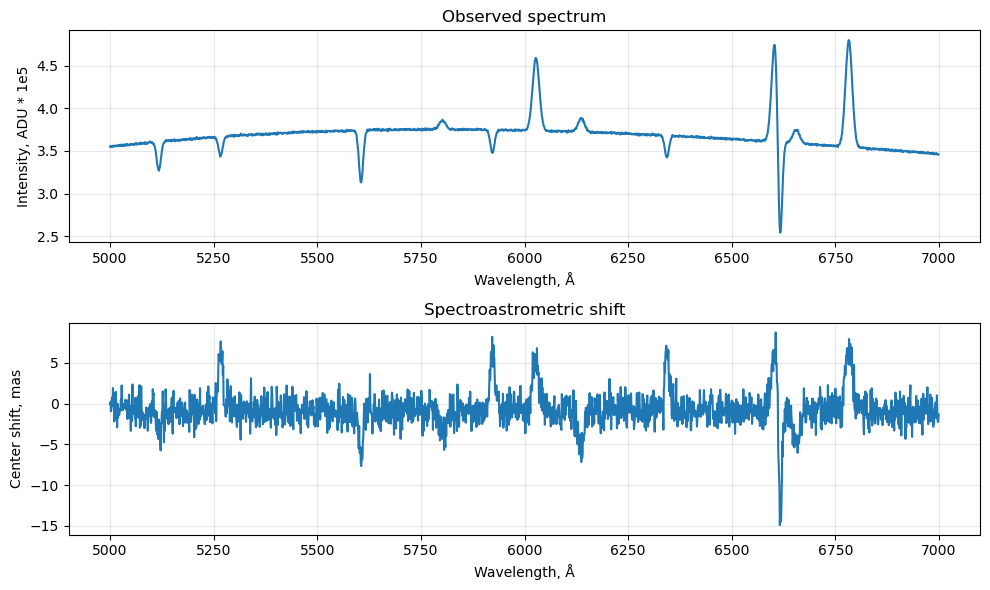

In [4]:
pix_size = 0.4   # pixel angular size, arcsec
area = 20        # half-width of the region across the dispersion direction in which the spectrum is analyzed

LAMBDA, SPEC, CENTER, FWHM, ERRORBAR = Center_search(CRVAL1, CDELT1, 0, image_size_X, area, Y_est, image)

fig2, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].plot(LAMBDA, SPEC / 1e5)
axes[0].set_xlabel("Wavelength, Å")
axes[0].set_ylabel("Intensity, ADU * 1e5")
axes[0].set_title("Observed spectrum")
axes[0].grid(True, alpha=0.3)

axes[1].plot(LAMBDA, (CENTER - CENTER[0]) * pix_size * 1000)
axes[1].set_xlabel("Wavelength, Å")
axes[1].set_ylabel("Center shift, mas")
axes[1].set_title("Spectroastrometric shift")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

It is evident that the spectrum contains emission lines which shift the center upwards and those that shift it downwards. This is because the former belong to the source located higher on the frame, and the latter to the one below. The same logic applies to absorption lines, but now the lines from the upper source shift the center downwards, while the lines from the lower source shift it upwards.

Now we can proceed to the second stage of processing: determining the angular separation between the sources. For this, we can use the `LCS_target` function, which is applied to individual lines and determines the position on the frame of the center of the source emitting in that particular line. Since we know how to distinguish the lines of each source by looking at the spectrum and the spectroastrometric curve, we can immediately state (see the code below) that the second and fourth lines under consideration belong to the "upper" source, while the first and third belong to the lower one. From this, the `sep` – the angular separation between the components – is easily found.

In [5]:
Line_1, Cont_1 = LCS_target(image, 266, 280, Y_est, area)   # the second absorbtion line
lc_1 = Line_1[2]

Line_2, Cont_2 = LCS_target(image, 605, 620, Y_est, area)   # the third absorbtion line
lc_2 = Line_2[2]

Line_3, Cont_3 = LCS_target(image, 1138, 1170, Y_est, area)  # the third emission line
lc_3 = Line_3[2]

Line_4, Cont_4 = LCS_target(image, 1782, 1810, Y_est, area)  # the last emission line
lc_4 = Line_4[2]

sep = (lc_2 + lc_4 - lc_1 - lc_3) / 2
# sep = 0.1 / pix_size #  uncomment this to make the spectra almost completely overlap (up to the noise level)

print("sep =", sep * pix_size, "arcsec")

sep = 0.10808529413853876 arcsec


We see that the derived separation agrees well with the true value of 0.1 arcsec. Now, knowing this separation, as well as the total spectrum and the spectroastrometric curve, we can reconstruct the spectra of each component of the observed binary source.

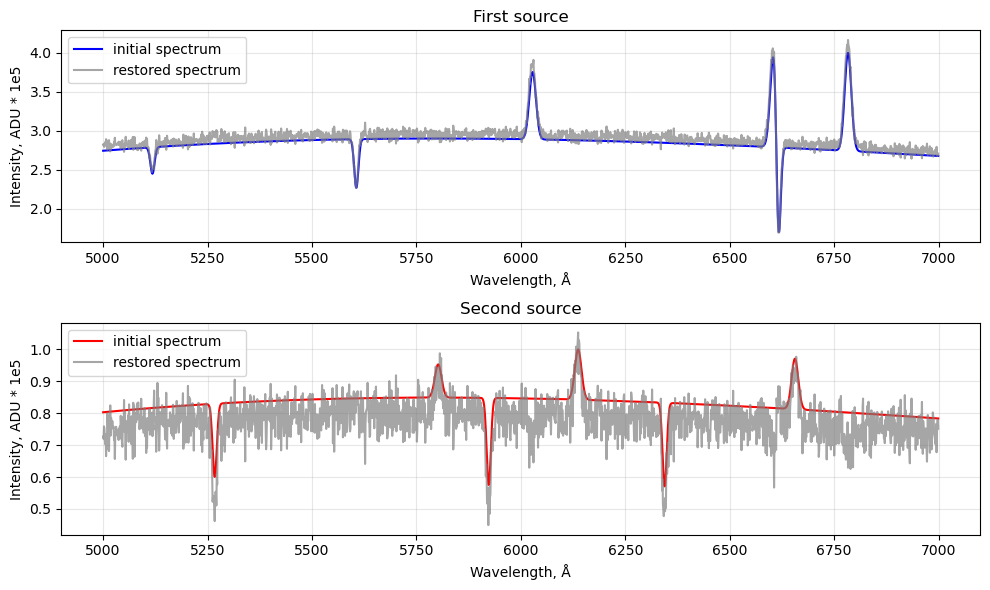

In [6]:
ref_center = (lc_2 + lc_4) / 2

SPEC1 = np.zeros(image_size_X)
SPEC2 = np.zeros(image_size_X)

for i in range(image_size_X):
    SPEC2[i] = ((ref_center - CENTER[i]) / sep) * SPEC[i]
    SPEC1[i] = SPEC[i] - SPEC2[i]


fig3, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].plot(wl, Int1 / 1e5, '-', color='blue', label='initial spectrum')
axes[0].plot(LAMBDA, SPEC1 / 1e5, '-', color='gray', alpha=0.7, label='restored spectrum')
axes[0].set_xlabel("Wavelength, Å")
axes[0].set_ylabel("Intensity, ADU * 1e5")
axes[0].set_title("First source")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(wl, Int2 / 1e5, '-', color='red', label='initial spectrum')
axes[1].plot(LAMBDA, SPEC2 / 1e5, '-', color='gray', alpha=0.7, label='restored spectrum')
axes[1].set_xlabel("Wavelength, Å")
axes[1].set_ylabel("Intensity, ADU * 1e5")
axes[1].set_title("Second source")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

In this example, we have covered only the core functions for spectroastrometric analysis. For more detailed information about them, as well as other functions in the `Spectroastrometry` module, please refer to the [documentation](https://github.com/DmitryLashinMSU/Spectroastrometry).